In [1]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# plot에 한국어 적용 
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 3s (3,380 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155047 files and d

### 데이터 전처리



*   결측치가 포함된 행 제거
*   출고량 단위 조정, 형 변환 ex) 백만단위로 조정 (10^-6)     1,500,000 -> 1.5
*   연도 조정, 형 변환 ex) 10 -> 2010, 95 -> 1995




In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

path = '/content/drive/MyDrive/codestates/Section1/project/vgames2.csv'
df = pd.read_csv(path)
print(df.shape)
df.head()

(16598, 10)


,Unnamed: 0,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,1,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,2,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,4,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04


In [2]:
df.dtypes

Unnamed: 0       int64
Name            object
Platform        object
Year           float64
Genre           object
Publisher       object
NA_Sales        object
EU_Sales        object
JP_Sales        object
Other_Sales     object
dtype: object

In [3]:
# 결측치가 포함된 행을 모두 제거
print(df.isnull().sum())
df = df.dropna(axis=0)

Unnamed: 0       0
Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64


In [4]:
print("Platform 목록:",df['Platform'].unique(),'\n')
print('Genre 목록:',df['Genre'].unique())

Platform 목록: ['DS' 'Wii' 'PSP' 'PS3' 'PC' 'PS' 'GBA' 'PS4' 'PS2' 'XB' 'X360' 'GC' '3DS'
 '2600' 'SAT' 'GB' 'NES' 'DC' 'N64' 'XOne' 'SNES' 'WiiU' 'PSV' 'GEN' 'SCD'
 'WS' 'NG' 'TG16' '3DO' 'GG' 'PCFX'] 

Genre 목록: ['Action' 'Adventure' 'Misc' 'Platform' 'Sports' 'Simulation' 'Racing'
 'Role-Playing' 'Puzzle' 'Strategy' 'Fighting' 'Shooter']


In [5]:
# 출고량에 대한 단위 조정, 형 변환
def tofloat(num):

    if num.find('K') != -1:
        num = float(num.replace('K','000')) * 1e-6 
    elif num.find('M') != -1:
          num = float(num.replace('M', ''))
    else :
        num = float(num)
    return num    

# 연도값을 모두 동일하게 조정, 형 변환
def toyear(year):

    if 0 <= year < 20:
      year = year + 2000

    elif 20 <= year < 100:
      year = year + 1900
    return year

df['Year'] = df['Year'].apply(lambda x: toyear(x))
df['NA_Sales'] = df['NA_Sales'].apply(lambda x: tofloat(x))
df['EU_Sales'] = df['EU_Sales'].apply(lambda x: tofloat(x))
df['JP_Sales'] = df['JP_Sales'].apply(lambda x: tofloat(x))
df['Other_Sales'] = df['Other_Sales'].apply(lambda x: tofloat(x))

In [6]:
df.dtypes

Unnamed: 0       int64
Name            object
Platform        object
Year           float64
Genre           object
Publisher       object
NA_Sales       float64
EU_Sales       float64
JP_Sales       float64
Other_Sales    float64
dtype: object

# 지역에 따라서 선호하는 게임 장르가 다를까?

**귀무가설 : 지역에 따라 선호하는 장르가 비슷할 것이다.** 

**대안가설 : 지역에 따라 선호하는 장르가 비슷하지 않을 것이다.** 


one-way ANOVA

In [7]:
# 일원 분산 분석을 위해 샘플 1000개를 수집하여 지역마다 장르의 출고량을 전처리
df_Genre = df.copy()
df_Genre = df_Genre[['Genre', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]

def sample_gener(df_Genre_sample, contry_sales):
    a = []
    df_Genre_sample = df_Genre_sample[['Genre', contry_sales]]

    for column in df_Genre_sample['Genre'].unique():
        sample = df_Genre_sample[(df_Genre_sample['Genre']==column)].rename(columns = {contry_sales : column}).reset_index().drop(['index', 'Genre'], axis=1)
        a.append(sample)
    return pd.concat(a, axis=1, ignore_index=False)

df_Genre_sample = df_Genre.sample(n=1000, random_state=42)

na_Sales = sample_gener(df_Genre_sample, 'NA_Sales').fillna(0).to_numpy()
eu_Sales = sample_gener(df_Genre_sample, 'EU_Sales').fillna(0).to_numpy()
jp_Sales = sample_gener(df_Genre_sample, 'JP_Sales').fillna(0).to_numpy()
other_Sales = sample_gener(df_Genre_sample, 'Other_Sales').fillna(0).to_numpy()

In [8]:
#일원 분산 분석을 통하여 "각 지역에 따라 선호하는 장르가 비슷하다." 라는 가설검정

from scipy.stats import f_oneway

na_anova = f_oneway(na_Sales[:, 0], na_Sales[:, 1], na_Sales[:, 2], na_Sales[:, 3], na_Sales[:, 4], 
         na_Sales[:, 5], na_Sales[:, 6], na_Sales[:, 7], na_Sales[:, 8], na_Sales[:, 9], na_Sales[:, 10], na_Sales[:, 11])

eu_anova = f_oneway(eu_Sales[:, 0], eu_Sales[:, 1], eu_Sales[:, 2], eu_Sales[:, 3], eu_Sales[:, 4], 
         eu_Sales[:, 5], eu_Sales[:, 6], eu_Sales[:, 7], eu_Sales[:, 8], eu_Sales[:, 9], eu_Sales[:, 10], eu_Sales[:, 11])

jp_anova = f_oneway(jp_Sales[:, 0], jp_Sales[:, 1], jp_Sales[:, 2], jp_Sales[:, 3], jp_Sales[:, 4], 
         jp_Sales[:, 5], jp_Sales[:, 6], jp_Sales[:, 7], jp_Sales[:, 8], jp_Sales[:, 9], jp_Sales[:, 10], jp_Sales[:, 11])

other_anova = f_oneway(other_Sales[:, 0], other_Sales[:, 1], other_Sales[:, 2], other_Sales[:, 3], other_Sales[:, 4], 
         other_Sales[:, 5], other_Sales[:, 6], other_Sales[:, 7], other_Sales[:, 8], other_Sales[:, 9], other_Sales[:, 10], other_Sales[:, 11])

print('na 일원 분산 분석:', na_anova)
print('eu 일원 분산 분석:', eu_anova)
print('jp 일원 분산 분석:', jp_anova)
print('other 일원 분산 분석:', other_anova)

na 일원 분산 분석: F_onewayResult(statistic=6.503997184404117, pvalue=9.082520517235201e-11)
eu 일원 분산 분석: F_onewayResult(statistic=4.262901918652679, pvalue=2.589136802755668e-06)
jp 일원 분산 분석: F_onewayResult(statistic=2.120047824501642, pvalue=0.0162670918620732)
other 일원 분산 분석: F_onewayResult(statistic=4.956518469200398, pvalue=1.1613592205322837e-07)


4개의 지역 모두 P-value값이 0과 근접 하여 대안가설인 "지역에 따라 선호하는 장르가 비슷하지 않을 것이다." 라는 가설을 채택할 수 있다.

**채택된 가설을 증명할 지역에 따른 장르별 출고량 Bar Chart**

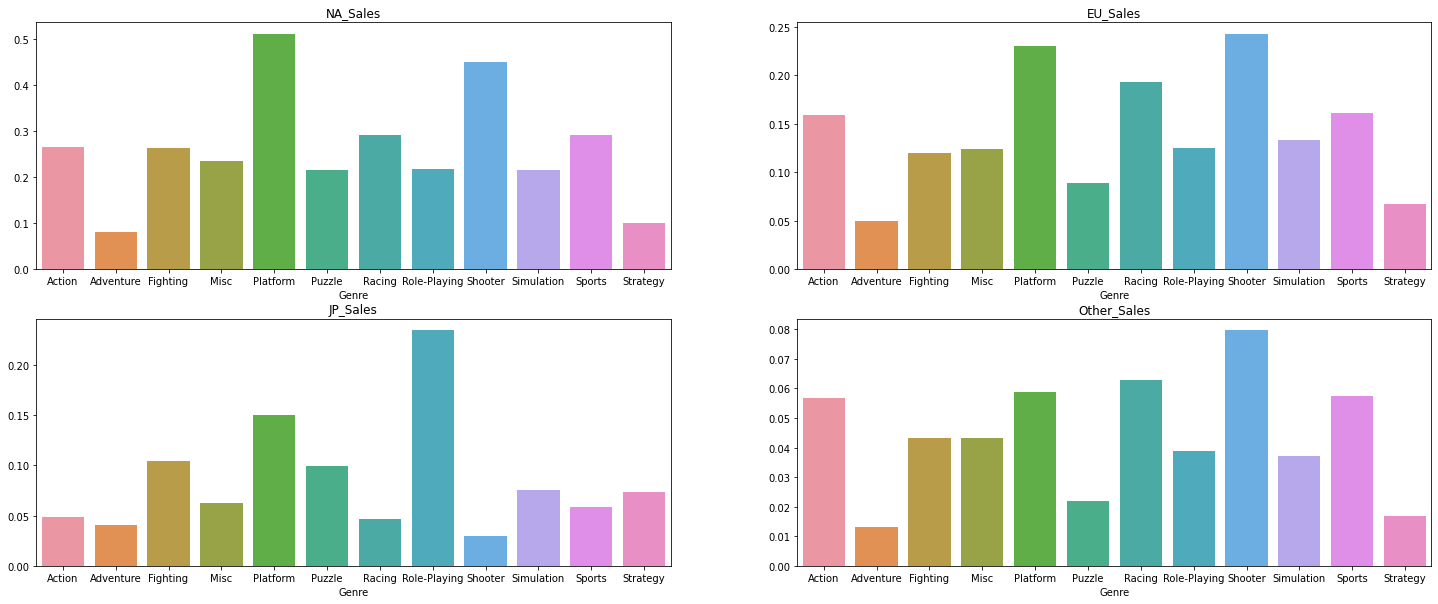

In [9]:
count=1
plt.figure(figsize=[25,10])
for column in df_Genre.columns[1:]:
    plt.subplot(2, 2, count)
    plt.title(column)
    sns.barplot(data=df_Genre[['Genre', column]].groupby('Genre').mean().T)
    count+=1 

**지역별 장르 선호 1순위, 2순위**

Na : Platform, Shooter

EU : Platform, Shooter

JP : Role-Playing, Platform

Other : Shooter, Racing

# 연도별 게임의 트렌드가 있을까?

**귀무가설 : 연도별 게임의 트렌트가 비슷할 것이다.**

**대안가설 : 연도별 게임의 트렌트가 비슷하지 않을 것이다.**

chi-squared test

In [10]:
# One, two sample chi-squared test
from scipy.stats import chisquare, chi2_contingency

df_ex = df.copy()
obs = pd.crosstab(df_ex['Year'], df_ex['Genre'])
obs1 = np.array(obs)

print(chisquare(obs1, axis=None))
print(chi2_contingency(obs, correction = False)[1])

Power_divergenceResult(statistic=33061.34911643371, pvalue=0.0)
0.0


One, two sample chi-squared test의 P-value 값이 모두 0이므로 연도별 장르의 분포는 비슷하지 않고, 서로 관련이 있어

대안가설인 "연도별 게임의 트렌트가 비슷하지 않을 것이다." 을 채택할 수 있다.




**채택된 가설을 증명할 연도별 장르 출고량 Line Chart**

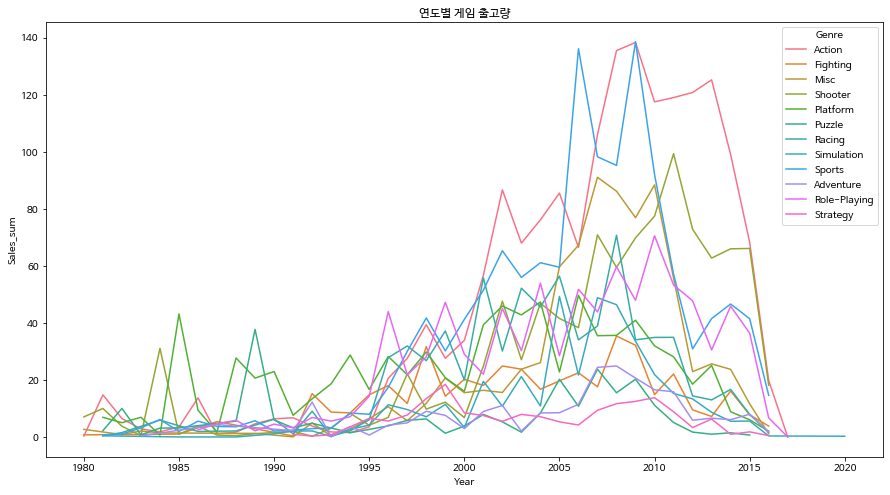

In [11]:
df_Year = df.copy()
df_Year = df_Year[['Year', 'Genre', 'NA_Sales',	'EU_Sales',	'JP_Sales',	'Other_Sales']]
df_Year['Sales_sum'] = df.loc[:, 'NA_Sales':].sum(axis=1)
df_Year = df_Year.drop(columns=['NA_Sales',	'EU_Sales',	'JP_Sales',	'Other_Sales'])

data = df_Year.groupby(['Year','Genre'] )['Sales_sum'].sum()
y = []
g = []
v = data.values
for i in range(len(data.index)):
  y.append(data.index[i][0])
  g.append(data.index[i][1])
data = np.array([y, g, v]).T
data1 = pd.DataFrame(data, columns=['Year', 'Genre', 'Sales_sum'])
data1['Year'] = pd.to_numeric(data1['Year'])
data1['Sales_sum'] = pd.to_numeric(data1['Sales_sum'])

plt.figure(figsize=[15, 8])
plt.rc('font', family='NanumBarunGothic') 
plt.title('연도별 게임 출고량')
sns.lineplot(x='Year', y='Sales_sum', data=data1, hue='Genre');

**연도를 5년 단위로 조정**

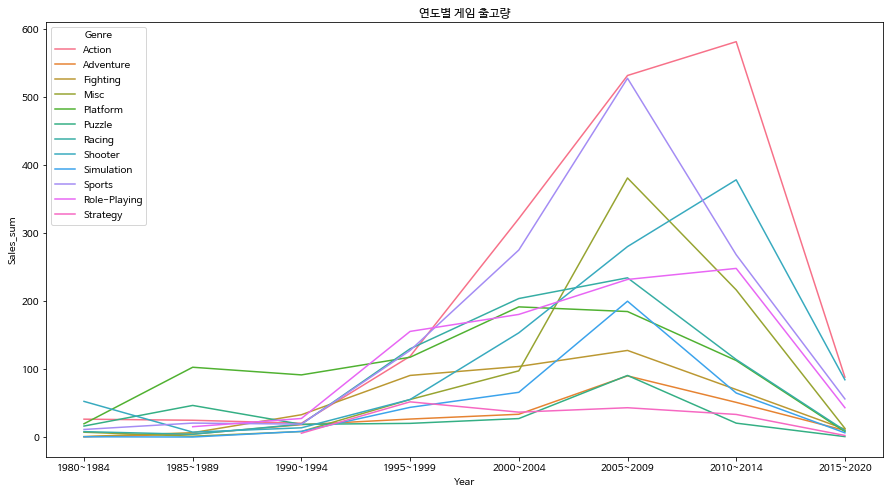

In [12]:
year = ['1980~1984', '1985~1989', '1990~1994', '1995~1999', '2000~2004', '2005~2009', '2010~2014', '2015~2020']
y = []
g = []
v = []

def data_gener(data, year1, year2):
    new_data = data[(data1['Year']>=year1) & (data['Year']<= year2)].groupby('Genre')['Sales_sum'].sum()
    for i in range(len(new_data.index)):
        y.append(year1)
        g.append(new_data.index[i])
    v.append(new_data.values)

data_gener(data1, 1980, 1984)
data_gener(data1, 1985, 1989)
data_gener(data1, 1990, 1994)
data_gener(data1, 1995, 1999)
data_gener(data1, 2000, 2004)
data_gener(data1, 2005, 2009)
data_gener(data1, 2010, 2014)
data_gener(data1, 2015, 2020)

data = np.array([y,g, np.concatenate(v)]).T
new_Year = pd.DataFrame(data, columns=['Year', 'Genre', 'Sales_sum'])
new_Year['Year']= new_Year['Year'].replace(new_Year['Year'].unique(), year)
new_Year['Sales_sum'] = pd.to_numeric(new_Year['Sales_sum'])

plt.figure(figsize=[15, 8])
plt.rc('font', family='NanumBarunGothic') 
plt.title('연도별 게임 출고량')
sns.lineplot(x='Year', y='Sales_sum', data=new_Year, hue='Genre');

**지역별 장르 선호**

1980 ~ 1984 : Shooter

1985 ~ 1994 : Platform

1995 ~ 1999 : Role-Playing

2000 ~ 2014 : Action

1995년 부터 Action, Sport장르가 급격한 성장을 하였다.

# 출고량이 높은 게임에 대한 분석 및 시각화 프로세스


**출고량 Top10 (Game, Publisher) Pie Chart**

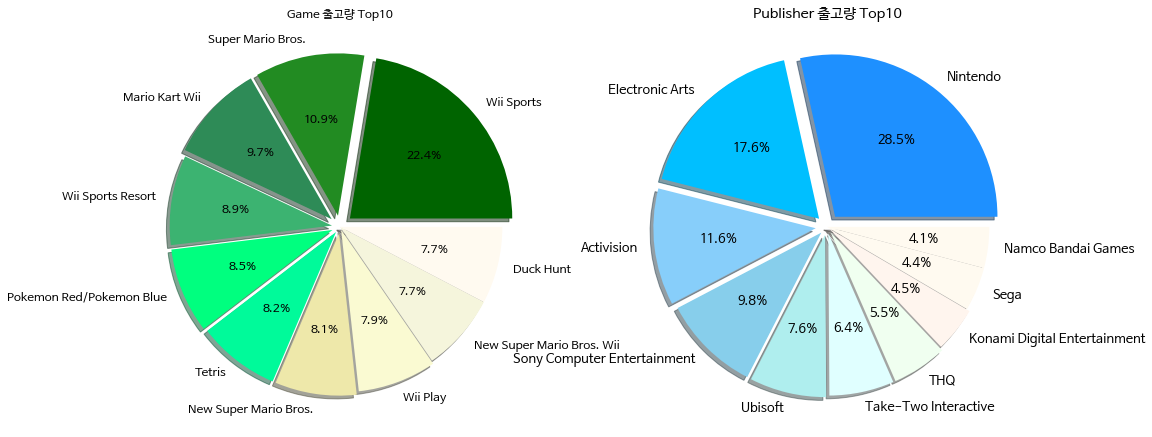

In [13]:
df_pie = df.copy()
df_pie = df_pie[['Name','Publisher', 'Year', 'Genre', 'NA_Sales',	'EU_Sales',	'JP_Sales',	'Other_Sales']]
df_pie['Sales_sum'] = df.loc[:, 'NA_Sales':].sum(axis=1)
df_pie = df_pie.drop(columns=['NA_Sales',	'EU_Sales',	'JP_Sales',	'Other_Sales'])
df_pie = df_pie.sort_values('Sales_sum', ascending=False)

colors1=['red', 'tomato', 'indianred', 'salmon', 'darksalmon', 'sandybrown', 'peachpuff','mistyrose', 'linen', 'lightyellow']
colors2=['purple', 'darkviolet', 'blueviolet', 'orchid', 'violet', 'plum','pink', 'bisque', 'papayawhip', 'oldlace']
colors4 = ['dodgerblue', 'deepskyblue', 'lightskyblue', 'skyblue', 'paleturquoise',  'lightcyan', 'honeydew', 
              'seashell', 'floralwhite', 'floralwhite']
colors3=['darkgreen','forestgreen', 'seagreen', 'mediumseagreen', 'springgreen', 
            'mediumspringgreen', 'palegoldenrod', 'lightgoldenrodyellow', 'beige', 'floralwhite']
colors=[colors1, colors2, colors3, colors4]

explode = [0.08, 0.07, 0.07, 0.05, 0.05, 0.04, 0.04, 0.02, 0, 0]

plt.figure(figsize=[16, 30])
plt.subplot(1, 2, 1)
plt.title('Game 출고량 Top10')
plt.rc('font', family='NanumBarunGothic', size=12) 
plt.pie(df_pie['Sales_sum'].iloc[:10], labels=df_pie['Name'].iloc[:10], autopct = '%1.1f%%', shadow=True, colors=colors[2], explode=explode);

df_pie = df_pie[['Publisher', 'Sales_sum']].groupby('Publisher').sum().sort_values('Sales_sum', ascending=False).reset_index()
plt.subplot(1, 2, 2)
plt.title('Publisher 출고량 Top10')
plt.rc('font', family='NanumBarunGothic', size=13) 
plt.pie(df_pie['Sales_sum'].iloc[:10], labels=df_pie['Publisher'].iloc[:10], autopct = '%1.1f%%', shadow=True, colors=colors[3], explode=explode);

출고량 Top3 Game: Wii Sports, Super Mario Bros,  Mario Kart Wii

출고량 Top3 Publisher: Nintendo, Electronic Arts, Activision



**지역별 출고량 Top10 (Game) Pie Chart**

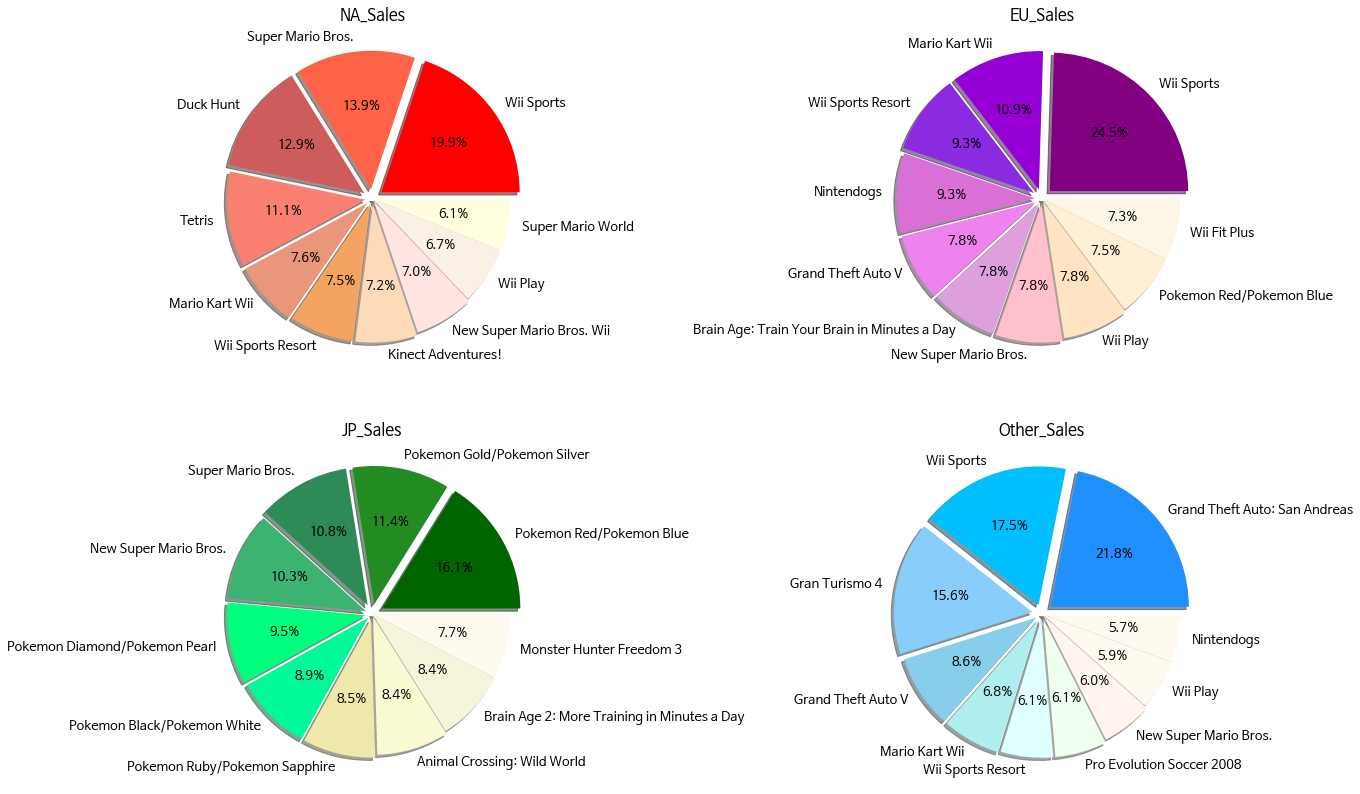

In [14]:
df_pie = df.copy()
df_pie = df_pie[['Name', 'NA_Sales',	'EU_Sales',	'JP_Sales',	'Other_Sales']]

count=1
plt.figure(figsize=[22,14])
for i in range(len(df_pie.columns[1:])):
    column = df_pie.columns[1:][i]
    df_pie = df_pie.sort_values(column, ascending=False)
    plt.subplot(2, 2, count)
    plt.title(column)
    plt.rc('font', family='NanumBarunGothic', size=13) 
    plt.pie(df_pie[column].iloc[:10], labels=df_pie['Name'].iloc[:10], autopct = '%1.1f%%', shadow=True, colors=colors[i], explode=explode);
    count+=1 

Na_Sales Top3 Game : Wii Sports, Super Mario Bros, Duck Hunt

EU_Sales Top3 Game : Wii Sports, Mario Karts Wii, Will Sport Resort

JP_Sales Top3 Game : Pokemon Red/Pokemon Blue, Pokemon Gold/Pokemon Silver, Super Mario Bros 

Other_Sales Top3 Game : Grand Theft Auot:San Andreas, Wii Sports, Gran Turismo4 

# 그 외 다른 문제 
## 최근 10년 동안 출시 된 게임 중 출고량이 낮은 게임을 제작한 회사와
## 그 회사는 왜 출고량이 낮을까?
### >  출고량이 낮은 회사의 게임은 지역별 최신 트렌드에 맞게 게임을 제작하지 않아 출고량이 낮을 것이다.  
**최근 10년 동안 지역별 Best Game Top3 VS Worst Game Top3**



최근 10년 동안 지역별 게임 출고량을 내림차순으로 정렬 후 맨 위3개, 맨 아래 3개의 행을 추출


In [21]:
na_Publisher = []
eu_Publisher = []
JS_Publisher = []
other_Publisher = []

df_Publisher = df.copy()
df_Publisher = df_Publisher[['Name', 'Year', 'NA_Sales',	'EU_Sales',	'JP_Sales',	'Other_Sales']]
df_Publisher = df_Publisher[df_Publisher['Year']>=2010]
df_Publisher = df_Publisher.drop('Year', axis=1)

# 출고량을 기준으로  Best, Worst Game선정
df_Publisher1 = df_Publisher.groupby('Name').sum().sort_values('NA_Sales', ascending=False)
for index in [0, 1, 2, -3, -2, -1]:
    na_Publisher.append(df_Publisher1[df_Publisher1['NA_Sales']>0.01].index[index])           # Worst Game의 기준을 0.02 이상 출고한 게임으로 지정 

df_Publisher2 = df_Publisher.groupby('Name').sum().sort_values('EU_Sales', ascending=False)
for index in [0, 1, 2, -3, -2, -1]:
    eu_Publisher.append(df_Publisher2[df_Publisher2['EU_Sales']>0.01].index[index])

df_Publisher3 = df_Publisher.groupby('Name').sum().sort_values('JP_Sales', ascending=False)
for index in [0, 1, 2, -3, -2, -1]:
    JS_Publisher.append(df_Publisher3[df_Publisher3['JP_Sales']>0.01].index[index])

df_Publisher4 = df_Publisher.groupby('Name').sum().sort_values('Other_Sales', ascending=False)
for index in [0, 1, 2, -3, -2, -1]:
    other_Publisher.append(df_Publisher4[df_Publisher4['Other_Sales']>0.01].index[index])

# Best, Worst Game의 행 추출
idmax=[]
for name in na_Publisher:
    idmax.append(df_Publisher[(df_Publisher['Name']==name)]['NA_Sales'].idxmax())
for name in eu_Publisher:
    idmax.append(df_Publisher[(df_Publisher['Name']==name)]['EU_Sales'].idxmax())
for name in JS_Publisher:
    idmax.append(df_Publisher[(df_Publisher['Name']==name)]['JP_Sales'].idxmax())
for name in other_Publisher:
    idmax.append(df_Publisher[(df_Publisher['Name']==name)]['Other_Sales'].idxmax())        

In [22]:
df_Genre = df.copy()
df_Genre = df_Genre[['Genre', 'Year', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]
df_Genre = df_Genre[df_Genre['Year']>=2010]
df_Genre = df_Genre.drop('Year', axis=1)

df_Platform = df.copy()
df_Platform = df_Platform[['Platform', 'Year', 'NA_Sales',	'EU_Sales',	'JP_Sales',	'Other_Sales']]
df_Platform = df_Platform[df_Platform['Year']>=2010]
df_Platform = df_Platform.drop('Year', axis=1)

지역별 Best Game Top3 VS Worst Game Top3 Data

북미 Genre, Platform 시각화(LIne, Pie Chart)

,Name,Platform,Year,Genre,Publisher,NA_Sales
10913,Grand Theft Auto V,X360,2013.0,Action,Take-Two Interactive,9.63
6248,Call of Duty: Black Ops,X360,2010.0,Shooter,Activision,9.67
2809,Call of Duty: Modern Warfare 3,X360,2011.0,Shooter,Activision,9.03
12383,Makai Shin Trillion,PSV,2014.0,Role-Playing,Idea Factory,0.02
7332,Mechanic Master 2,DS,2010.0,Puzzle,Crave Entertainment,0.02
13300,Canada Hunt,Wii,2010.0,Sports,Virtual Play Games,0.02


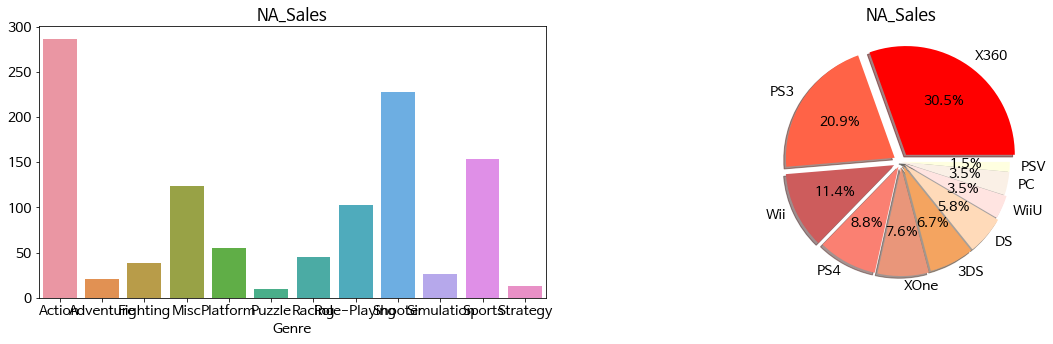

In [28]:
df_pie = df_Platform.groupby('Platform')['NA_Sales'].sum()
df_pie = pd.DataFrame(df_pie).sort_values('NA_Sales', ascending=False)
plt.figure(figsize=[20,5])
plt.subplot(1, 2, 1)
plt.title('NA_Sales')
plt.rc('font', family='NanumBarunGothic', size=14) 
sns.barplot(data=df_Genre[['Genre', 'NA_Sales']].groupby('Genre').sum().T);
plt.subplot(1, 2, 2)
plt.title('NA_Sales')
plt.pie(df_pie['NA_Sales'].iloc[:10], labels=df_pie.index[:10], autopct = '%1.1f%%', shadow=True, colors=colors[0], explode=explode);
df.loc[idmax[:6], ['Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales']]

best 게임은 해당 기간에 유행하는 장르(액션, 슈터)와 플렛폼(X360) 잘 반영하여 출고량이 높다.

worst게임은 비교적 덜 선호되는 장르와 플렛폼을 사용했다는 특징을 보이고 있다.


유럽 Best Game Top3 VS Worst Game Top3 Data

Genre, Platform 시각화(LIne, Pie Chart)

,Name,Platform,Year,Genre,Publisher,EU_Sales
3483,Grand Theft Auto V,PS3,2013.0,Action,Take-Two Interactive,9.27
3079,FIFA 15,PS4,2014.0,Sports,Electronic Arts,4.29
14120,Call of Duty: Modern Warfare 3,PS3,2011.0,Shooter,Activision,5.82
13743,Tournament of Legends,Wii,2010.0,Fighting,Sega,0.02
6347,Aegis of Earth: Protonovus Assault,PSV,2016.0,Action,PQube,0.01
11858,Captain Tsubasa: New Kick Off,DS,2010.0,Sports,Konami Digital Entertainment,0.02


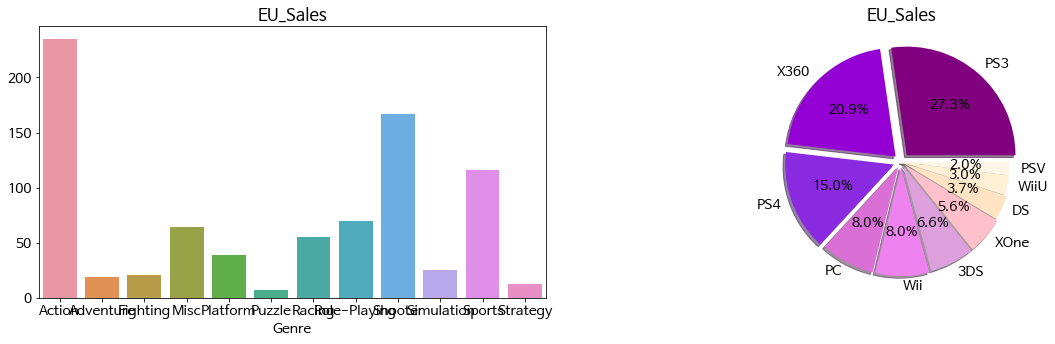

In [18]:
df_pie = df_Platform.groupby('Platform')['EU_Sales'].sum()
df_pie = pd.DataFrame(df_pie).sort_values('EU_Sales', ascending=False)
plt.figure(figsize=[20,5])
plt.subplot(1, 2, 1)
plt.title('EU_Sales')
plt.rc('font', family='NanumBarunGothic', size=14) 
sns.barplot(data=df_Genre[['Genre', 'EU_Sales']].groupby('Genre').sum().T);
plt.subplot(1, 2, 2)
plt.title('EU_Sales')
plt.pie(df_pie['EU_Sales'].iloc[:10], labels=df_pie.index[:10], autopct = '%1.1f%%', shadow=True, colors=colors[1], explode=explode);
df.loc[idmax[6:12], ['Name', 'Platform', 'Year', 'Genre', 'Publisher', 'EU_Sales']]

일본 Best Game Top3 VS Worst Game Top3 Data

Genre, Platform 시각화(LIne, Pie Chart)

,Name,Platform,Year,Genre,Publisher,JP_Sales
10621,Pokemon Black/Pokemon White,DS,2010.0,Role-Playing,Nintendo,5.65
1847,Monster Hunter Freedom 3,PSP,2010.0,Role-Playing,Capcom,4.87
8906,Animal Crossing: New Leaf,3DS,2012.0,Simulation,Nintendo,4.36
1189,Shin Hisui no Shizuku: Hiiro no Kakera 2 Portable,PSP,2010.0,Adventure,Idea Factory,0.02
4937,Prince of Persia: The Forgotten Sands,PSP,2010.0,Action,Ubisoft,0.01
5567,Summon Night Granthese: Horobi no Ken to Yakus...,PS2,2010.0,Role-Playing,Namco Bandai Games,0.02


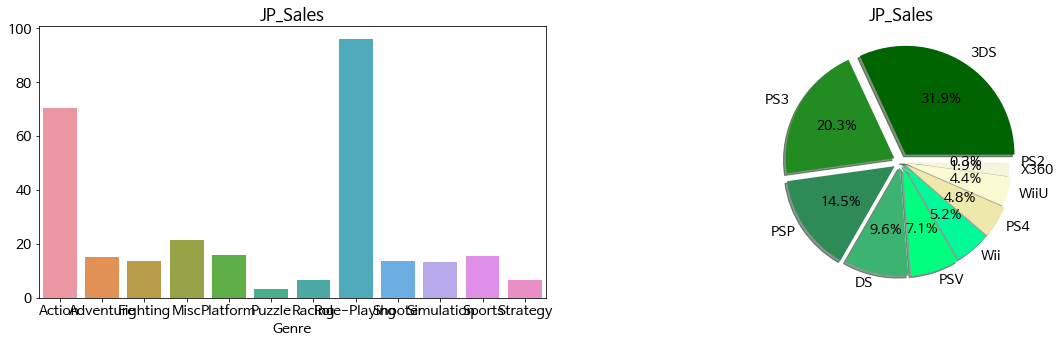

In [19]:
df_pie = df_Platform.groupby('Platform')['JP_Sales'].sum()
df_pie = pd.DataFrame(df_pie).sort_values('JP_Sales', ascending=False)
plt.figure(figsize=[20,5])
plt.subplot(1, 2, 1)
plt.title('JP_Sales')
plt.rc('font', family='NanumBarunGothic', size=14) 
sns.barplot(data=df_Genre[['Genre', 'JP_Sales']].groupby('Genre').sum().T);
plt.subplot(1, 2, 2)
plt.title('JP_Sales')
plt.pie(df_pie['JP_Sales'].iloc[:10], labels=df_pie.index[:10], autopct = '%1.1f%%', shadow=True, colors=colors[2], explode=explode);
df.loc[idmax[:6], ['Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales']]
df.loc[idmax[12:18], ['Name', 'Platform', 'Year', 'Genre', 'Publisher', 'JP_Sales']]

'Prince of Persia: The Forgotten Sands'는 어느정도 선호하는 장르, 플렛폼을 사용한 게임이지만 
worst케이스에 속해 있다.

기타 지역 Best Game Top3 VS Worst Game Top3 Data

Genre, Platform 시각화(LIne, Pie Chart)

,Name,Platform,Year,Genre,Publisher,Other_Sales
3483,Grand Theft Auto V,PS3,2013.0,Action,Take-Two Interactive,4.14
4240,Call of Duty: Black Ops II,PS3,2012.0,Shooter,Activision,2.52
9070,Call of Duty: Black Ops 3,PS4,2015.0,Shooter,Activision,2.31
11534,FlingSmash,Wii,2010.0,Action,Nintendo,0.02
12999,Hyperdimension Idol Neptunia PP,PSV,2013.0,Misc,Namco Bandai Games,0.02
4955,DECA Sports Freedom,X360,2010.0,Sports,Hudson Soft,0.02


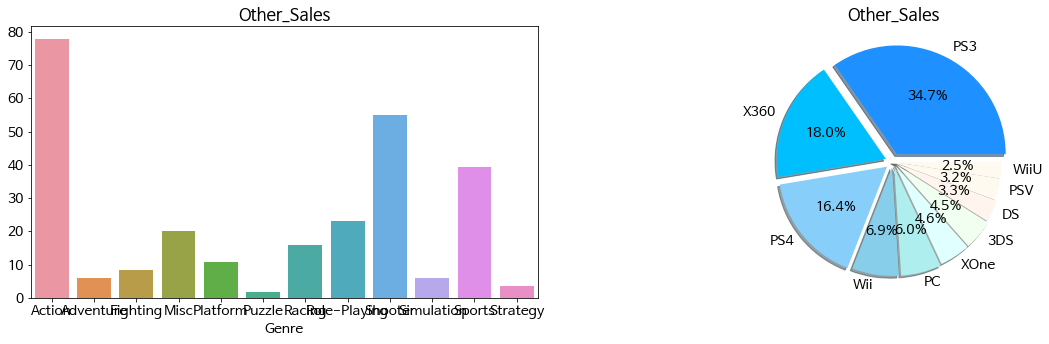

In [20]:
df_pie = df_Platform.groupby('Platform')['Other_Sales'].sum()
df_pie = pd.DataFrame(df_pie).sort_values('Other_Sales', ascending=False)
plt.figure(figsize=[20,5])
plt.subplot(1, 2, 1)
plt.title('Other_Sales')
plt.rc('font', family='NanumBarunGothic', size=14) 
sns.barplot(data=df_Genre[['Genre', 'Other_Sales']].groupby('Genre').sum().T);
plt.subplot(1, 2, 2)
plt.title('Other_Sales')
plt.pie(df_pie['Other_Sales'].iloc[:10], labels=df_pie.index[:10], autopct = '%1.1f%%', shadow=True, colors=colors[3], explode=explode);
df.loc[idmax[18:24], ['Name', 'Platform', 'Year', 'Genre', 'Publisher', 'Other_Sales']]

# 최종 결론
위와 같은 분석으로 출고량이 낮은 게임을 제작한 회사는 게임을 제작할 때 해당 
시기에 

유행하는 트렌드에 맞게 소비자가 선호하는 게임을 제작할 필요가 있다는 결론이 나왔습니다.